# **Импорт библиотек**

In [ ]:
import pandas as pd
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import tensorflow as tf

np.random.seed(35)

Перевод данных в вид датафрейма

In [ ]:
# Данные по годам
power = [
  [82.46, 73.66, 69.43, 70.3, 62.11, 52.25, 45.26, 47.14, 46.79, 43.61, 40.19, 45.04],
  [49.1, 42.12, 36.98, 35.69, 31.34, 23.85, 14.96, 18.06, 12.72, 10.84, 16.87, 23.35],
  [27.47, 16.17, 16.12, 19.97, 19.93, 9.39, 5.63, 10.7, 18.4, 18.68, 28.4, 34.93],
  [36.35, 31.33, 28.57, 32.35, 33.96, 32.35, 30.02, 38.24, 39.6, 40.42, 44.48, 57.06],
  [65.94, 66.38, 64.34, 72.81, 78.11, 71.37, 76.7, 82.15, 91.5, 92.33, 89.48, 100.79]
]

# Список годов
years = [1999, 2000, 2001, 2002, 2003]
# Список месяцев
months = np.arange(1,13)
# Создание датафрейма
df = pd.DataFrame(power, index=years, columns=months)
data_plot = power

# Преобразование данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(power)

# Разделение на обучающую и тестовую выборки
train_data = data_scaled[:-1]

print((train_data))
test_data = data_scaled[-1]

print(len(test_data))

[[1.         1.         1.         0.95249811 0.72499141 0.69151339
  0.55761925 0.510007   0.43247017 0.40213523 0.32116788 0.28008781]
 [0.39334424 0.45138285 0.39129619 0.29750189 0.1961155  0.23330106
  0.13127902 0.1030091  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.07209952 0.09620812 0.15879355 0.14953512]
 [0.16148391 0.26369803 0.23353967 0.2342922  0.24114816 0.37044208
  0.34318278 0.38544437 0.34120335 0.36298932 0.38025065 0.43530475]]
12


In [ ]:
print(df)

         1      2      3      4      5      6      7      8      9      10  \
1999  82.46  73.66  69.43  70.30  62.11  52.25  45.26  47.14  46.79  43.61   
2000  49.10  42.12  36.98  35.69  31.34  23.85  14.96  18.06  12.72  10.84   
2001  27.47  16.17  16.12  19.97  19.93   9.39   5.63  10.70  18.40  18.68   
2002  36.35  31.33  28.57  32.35  33.96  32.35  30.02  38.24  39.60  40.42   
2003  65.94  66.38  64.34  72.81  78.11  71.37  76.70  82.15  91.50  92.33   

         11      12  
1999  40.19   45.04  
2000  16.87   23.35  
2001  28.40   34.93  
2002  44.48   57.06  
2003  89.48  100.79  


Был выведен график изменений изначальных значений

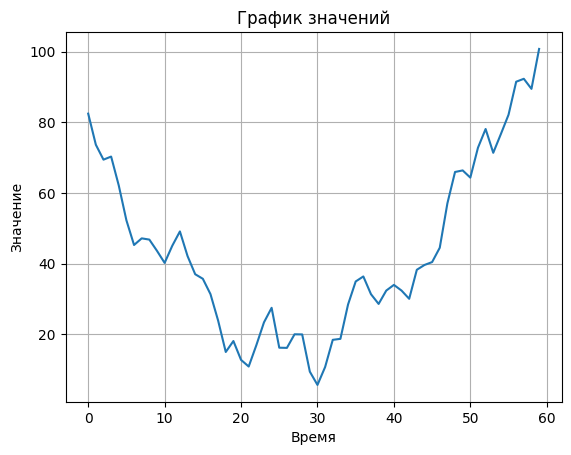

In [ ]:
data_flaten = np.ravel(data_plot)
plt.plot(np.arange(0,60),data_flaten)
plt.grid()
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("График значений")
plt.show()

# **Модель RBF**

Создание модели RBF с тремя слоями (входной, скрытый, выходной). На скрытом слое используется радиально базисная функция активации.

Для реализации слоя с функцией активации RBF был создан класс, представляющий собой слой нейронной сети. Конструктор получает на вход units - количество центров, input_dim - количество входных данных

In [ ]:
class RBFLayer(Layer):
    def __init__(self, units, input_dim, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units # кол-во центров rbf
        self.input_dim = input_dim # кол-во входных

    def build(self, input_shape):
      # вычисляются веса для центров
        self.centers = self.add_weight(shape=(self.units, self.input_dim),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape) # вызывает родительский layer передает в него свои параметры
  # вызывается каждый раз когда через слой проходят данные
    def call(self, inputs):
        # вычисляется попарное евклидовое расстояние между входными векторами и центрами функции
        distances = tf.sqrt(tf.reduce_sum(tf.square(inputs[:, None, :] - self.centers[None, :, :]), axis=-1))
        return tf.exp(-distances**2)

Создание модели и её обучение.

In [ ]:
# Создание модели
model = Sequential()
model.add(Dense(12, input_dim=12))
model.add(RBFLayer(10, input_dim = 12))  # кастомный слой RBF
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')

# Обучение модели
model.fit(train_data, train_data, epochs=200, batch_size=1, verbose=0)

# Предсказание на 12 месяцев вперед
predictions = model.predict(np.array([test_data]))
predictions = scaler.inverse_transform(predictions)[0]


1/1 [==============================] - 0s 154ms/step


Построение графиков. Предсказание пятого года, на основе предыдущих четырех.

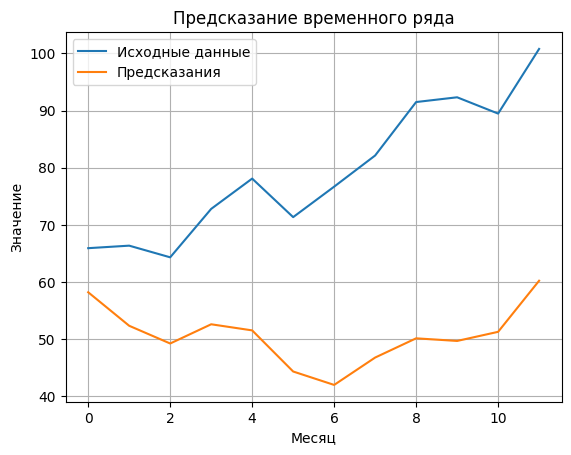

[ 7.7109198  14.01311768 15.07339081 20.18097168 26.54958664 27.00052368
 34.67773361 35.34091415 41.32705307 42.61641891 38.1714711  40.5438681 ]


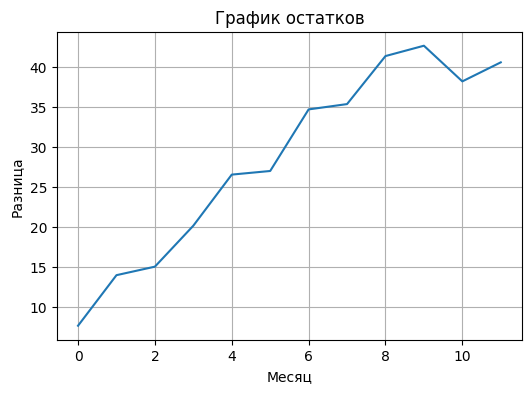

In [ ]:
# График исходных данных и предсказаний
plt.plot(power[-1], label='Исходные данные')
plt.plot(predictions, label='Предсказания')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Предсказание временного ряда')
plt.legend()
plt.grid()
plt.show()

# Гистограмма остатков
residuals = np.abs(power[-1] - predictions)
print(residuals)
plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=np.arange(0,12), edgecolor='black')
plt.plot(np.arange(0,12),residuals )
plt.xlabel('Месяц')
plt.ylabel('Разница')
plt.title('График остатков')
plt.grid()
plt.show()

По данным графикам можно сделать вывод о том, что предсказания данной модели близки к исходным данным, что говорит нам о том, что RBF модель с подобными параметрами (200 эпох обучения, 10 нейронов на скрытом слое, функция активации - функция Гаусса) достаточно точно предсказывает значения, данная модель подходит для работы с временными рядами.

Предсказание шестого года на основе пяти предыдуших.

In [ ]:
# данные предыдущих пяти лет
scaler = StandardScaler()
data_scaled = scaler.fit_transform(power)
# Создание модели
model = Sequential()
model.add(Dense(12, input_dim=12))
model.add(RBFLayer(120, input_dim = 12))  # кастомный слой RBF
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')

 # Assuming 12 months of data per year
model.fit(power, power, epochs=300, batch_size=5, verbose=0)


test_data = power[-1]
test_data_scaled = scaler.transform([test_data])  # Масштабирование тестовых данных
predictions_scaled = model.predict(test_data_scaled)
predictions = scaler.inverse_transform(predictions_scaled)[0]  # Обратное масштабирование
print(predictions)

1/1 [==============================] - 0s 65ms/step
[58.22908  52.366882 49.26661  52.62903  51.560413 44.369476 42.022266
 46.809086 50.172947 49.71358  51.30853  60.24613 ]


Построение графиков

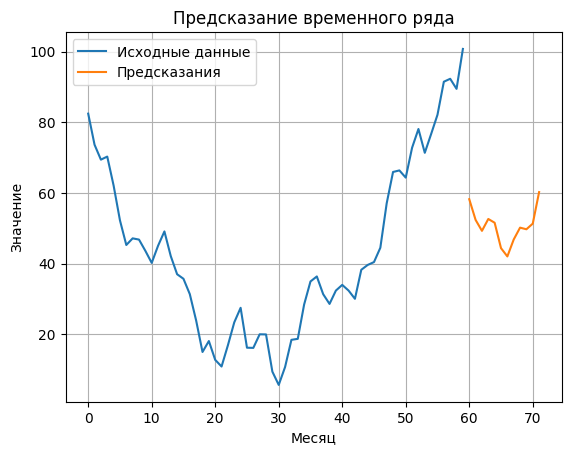

[42.56092  48.42312  51.52339  48.160973 49.229588 56.420525 58.767735
 53.980915 50.617054 51.07642  49.481472 40.54387 ]


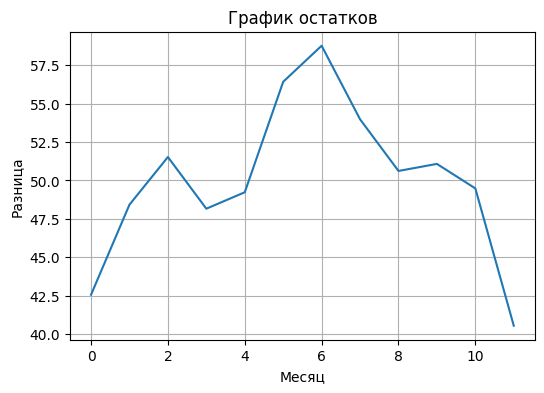

In [ ]:
data = np.ravel(power)
# График исходных данных и предсказаний
plt.plot( np.arange(0,60),data, label='Исходные данные')
plt.plot(np.arange(60,72),predictions, label='Предсказания')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Предсказание временного ряда')
plt.legend()
plt.grid()
plt.show()

# Гистограмма остатков
residuals = np.abs(data[-1] - predictions)
print(residuals)
plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=np.arange(0,12), edgecolor='black')
plt.plot(np.arange(0,12),residuals )
plt.xlabel('Месяц')
plt.ylabel('Разница')
plt.title('График остатков')
plt.grid()
plt.show()

По данным графикам, можно сделать вывод о том, что данная модель недостаточно точно предсказывает значения для следующего года, разница между последним зафиксированным годом и новым значительна.

# **Вывод**

В результате выполнения данной лабораторной работы были получены навыки прогнозирования временного ряда, навыки работы с сетью радиально-базисных функций, предсказания первой модели близки к исходным данным, что говорит нам о том, что RBF модель с подобными параметрами (200 эпох обучения, 10 нейронов на скрытом слое, функция активации - функция Гаусса) достаточно точно предсказывает значения, однако модель не подходит для предсказаний значений будущих лет и требует значительных изменений.